# Support Vector Machine on Amazon Food Reviews

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 Number of users: 256,059 Number of products: 74,258 Timespan: Oct 1999 - Oct 2012 Number of Attributes/Columns in data: 10

Attribute Information:

1.  index
2.  Id
3.  ProductId - unique identifier for the product
4.  UserId - unqiue identifier for the user
5.  ProfileName
6.  HelpfulnessNumerator - number of users who found the review helpful
7.  HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
8.  Score - rating between 1 and 5
9.  Time - timestamp for the review
10. Summary - brief summary of the review
11. Text - text of the review
12. ProcessedText - Cleaned & Preprocessed Text of the review

**Objective: Given Amazon Food reviews, convert all the reviews into a vector using four techniques: **<br>
**1. TFIDF.**<br>
**2. Average W2V.**<br>
**3. Average TFIDF-W2V.**<br>

**Then perform following tasks under each technique:**<br>
**Task 1. Split train and test data in a ratio of 80:20.** <br>
**Task 2. Perform GridSearch Cross Validation and Random Search Cross Validation to find optimal Value of C and Gamma.**<br>
**Task 3. Apply Support Vector Machine using RBF kernel and report accuracy.**<br>
**Task 4. Check for train error.**<br>

[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

Loading the data

SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently. Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [6]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plot

from gensim.models import Word2Vec
import gensim
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV

from wordcloud import WordCloud

In [7]:
connection = sqlite3.connect('FinalAmazonFoodReviewsDataset.sqlite')

In [8]:
data = pd.read_sql_query("SELECT * FROM Reviews", connection)

In [9]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,have bought sever the vital can dog food produ...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut the pean...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this confect that has been around few centuri ...
3,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price there was wide assort ...
4,5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,Positive,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,got wild hair for taffi and order this five po...


In [10]:
data.shape

(364171, 12)

In [11]:
data["Score"].value_counts()

Positive    307061
Negative     57110
Name: Score, dtype: int64

In [12]:
def changingScores(score):
    if score == "Positive":
        return 1
    else:
        return -1

In [13]:
# changing score
# Positive = 1
# Negative = -1
actualScore = list(data["Score"])                                                                                         
positiveNegative = list(map(changingScores, actualScore)) #map(function, list of numbers)
data['Score'] = positiveNegative

In [14]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,have bought sever the vital can dog food produ...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,-1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut the pean...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this confect that has been around few centuri ...
3,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price there was wide assort ...
4,5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,1,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,got wild hair for taffi and order this five po...


In [15]:
allPositiveReviews = data[(data["Score"] == 1)]

In [16]:
allPositiveReviews.shape

(307061, 12)

In [17]:
positiveReviews_5000 = allPositiveReviews[:5000]

In [18]:
positiveReviews_5000.shape

(5000, 12)

In [19]:
positiveReviews_5000.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,have bought sever the vital can dog food produ...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this confect that has been around few centuri ...
3,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price there was wide assort ...
4,5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,1,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,got wild hair for taffi and order this five po...
5,6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,1,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,this saltwat taffi had great flavor and was ve...


In [20]:
allNegativeReviews = data[(data["Score"] == -1)]

In [21]:
allNegativeReviews.shape

(57110, 12)

In [22]:
negativeReviews_5000 = allNegativeReviews[:5000]

In [23]:
negativeReviews_5000.shape

(5000, 12)

In [24]:
negativeReviews_5000.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,-1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut the pean...
11,12,13,B0009XLVG0,A327PCT23YH90,LT,1,1,-1,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...,cat have been happili eat felida platinum for ...
15,16,17,B001GVISJM,A3KLWF6WQ5BNYO,Erica Neathery,0,0,-1,1348099200,poor taste,I love eating them and they are good for watch...,love eat them and they are good for watch and ...
25,26,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,-1,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan...",the candi just red flavor just plan and chewi ...
45,47,51,B001EO5QW8,A108P30XVUFKXY,Roberto A,0,7,-1,1203379200,Don't like it,"This oatmeal is not good. Its mushy, soft, I d...",this oatmeal not good it mushi soft dont like ...


In [25]:
frames_10000 = [positiveReviews_5000, negativeReviews_5000]

In [26]:
FinalPositiveNegative = pd.concat(frames_10000)

In [27]:
FinalPositiveNegative.shape

(10000, 12)

In [28]:
#Sorting FinalDataframe by "Time"
FinalSortedPositiveNegative_10000 = FinalPositiveNegative.sort_values('Time', axis=0, ascending=True, inplace=False)

In [29]:
FinalSortedPositiveNegativeScore_10000 = FinalSortedPositiveNegative_10000["Score"]

In [30]:
FinalSortedPositiveNegative_10000.shape

(10000, 12)

In [31]:
FinalSortedPositiveNegativeScore_10000.shape

(10000,)

In [32]:
Data = FinalSortedPositiveNegative_10000

In [33]:
Data_Labels = FinalSortedPositiveNegativeScore_10000

In [34]:
print(Data.shape)
print(Data_Labels.shape)

(10000, 12)
(10000,)


In [35]:
Data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
772,1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,this was realli good idea and the final produc...
771,1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,just receiv shipment and could hard wait tri t...
5822,7427,8111,B0000EIE2Z,A3M174IC0VXOS2,Gail Cooke,3,3,1,1075420800,BEST BLUEBERRIES,In the winter when fresh blueberries exceed ou...,the winter when fresh blueberri exceed our foo...
2418,3481,3783,B00016UX0K,AF1PV3DIC0XM7,Robert Ashton,1,2,1,1081555200,Classic Condiment,Mae Ploy Sweet Chili Sauce is becoming a stand...,mae ploy sweet chili sauc becom standard condi...
5206,6790,7432,B0001E1IME,A2IKCTD1I73PLW,Adeba,2,8,1,1083456000,amazon monopoly/ripoff,love the snack. wanted to buy a bunch.<p>ship...,love the snack want buy bunch ship amazon more...


## 1. TFIDF

In [36]:
positive_reviews = Data[(Data["Score"] == 1)]
negative_reviews = Data[(Data["Score"] == -1)]

In [37]:
positive_reviews.shape, negative_reviews.shape

((5000, 12), (5000, 12))

In [38]:
Positive_tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), stop_words = "english")
Positive_tf_idf = Positive_tf_idf_vect.fit_transform(positive_reviews["ProcessedText"].values)

In [39]:
Positive_tf_idf.shape

(5000, 114651)

In [40]:
features = Positive_tf_idf_vect.get_feature_names()

In [41]:
idfValues = Positive_tf_idf_vect.idf_

In [45]:
d = dict(zip(features, 9 - idfValues))

In [46]:
sortedDict = sorted(d.items(), key = lambda d: d[1], reverse = True)

In [47]:
for i in range(200):
    print(sortedDict[i])

('like', 6.809072442421418)
('tast', 6.765368008186689)
('great', 6.763992492151379)
('good', 6.73466078043391)
('love', 6.689725684788852)
('flavor', 6.590032302691801)
('use', 6.568508292946707)
('just', 6.50636578331954)
('veri', 6.503690792870237)
('product', 6.470097075582087)
('tri', 6.467323148699362)
('make', 6.391361607896317)
('buy', 6.114608605976726)
('onli', 6.072907876777782)
('time', 6.060468186302143)
('realli', 6.049279258384337)
('best', 5.968767617525185)
('price', 5.95030555468545)
('littl', 5.909095286038787)
('dont', 5.886181026515912)
('order', 5.886181026515912)
('amazon', 5.849077276312534)
('store', 5.833492545295836)
('eat', 5.817661080079155)
('coffe', 5.8141086784747875)
('becaus', 5.806965790962407)
('recommend', 5.797964830103432)
('better', 5.790705270090627)
('mix', 5.726773729244833)
('ive', 5.650123319469437)
('ani', 5.631075124498743)
('high', 5.624644234168453)
('food', 5.594074168083775)
('bag', 5.591854411345462)
('drink', 5.580681110747337)
('yea

In [50]:
def PlotWordCloud(frequency):
    worcloudPlot = WordCloud(background_color="white", width=1500, height=1000)
    worcloudPlot.generate_from_frequencies(frequencies=frequency)
    plot.figure(figsize=(15,10))
    plot.imshow(worcloudPlot, interpolation="bilinear")
    plot.axis("off")
    plot.show()

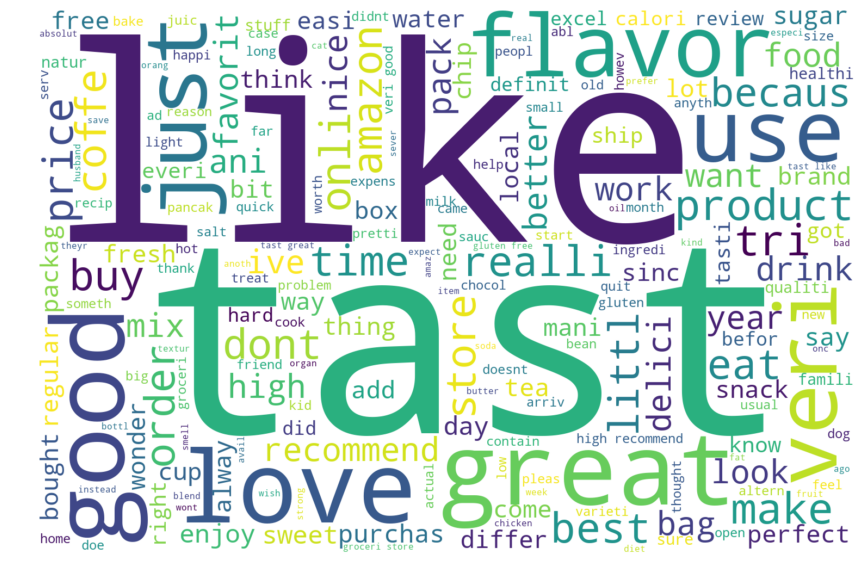

In [51]:
PlotWordCloud(d)

**This is a Word Cloud for all the positive reviews in the corpus.**<br>
**This Word Cloud plot correponds to the most frequent words in all positive reviews based on IDF values. More is the IDF Value for a word the less frequent is the word in the corpus.**

How I have plotted this word cloud.
Now formulae for IDF(D,Wi) = (ln(N+1 / ni+1) + 1) where 'N' is total number of documents in a corpus and 'ni' is the total number of documents where word 'Wi' occurs. Hence, I got all the idf values from idf_ attribute and I got corresponding features from get_features_names() function. Now since, the highest possible idf value can be 8.88, hence, I subtracted all the idf values from '9' which leads to the highest idf value of the most frequently occuring word. Now I created dictionary where features are the keys and modified idf value are the values and I feeded this to the word cloud and plot the same.
The same is done for negative reviews as well.

In [52]:
Negative_tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), stop_words = "english")
Negative_tf_idf = Negative_tf_idf_vect.fit_transform(negative_reviews["ProcessedText"].values)

In [53]:
Negative_tf_idf.shape

(5000, 139161)

In [54]:
features_neg = Negative_tf_idf_vect.get_feature_names()

In [55]:
negIDF = Negative_tf_idf_vect.idf_

In [56]:
NegD = dict(zip(features_neg, 9 - negIDF))

In [57]:
sortedDictNeg = sorted(NegD.items(), key = lambda NegD: NegD[1], reverse = True)

In [58]:
for i in range(200):
    print(sortedDictNeg[i])

('tast', 7.0050070599682215)
('like', 7.004466080782725)
('product', 6.762615081465285)
('just', 6.6496447054933165)
('veri', 6.595748937288184)
('tri', 6.565994676206391)
('good', 6.44957396719508)
('flavor', 6.4170040385096545)
('use', 6.376263183183732)
('buy', 6.343270500029383)
('dont', 6.271578571573267)
('becaus', 6.170961542527858)
('onli', 6.1211746177476165)
('make', 6.113290214223468)
('time', 6.082477327793933)
('order', 6.054889371275104)
('realli', 6.047871798616457)
('look', 6.009101688151887)
('love', 5.951857145376868)
('food', 5.95030555468545)
('eat', 5.9314962227279535)
('bought', 5.923553369214017)
('disappoint', 5.889486814650411)
('ani', 5.862729365480861)
('packag', 5.861033012232683)
('better', 5.8473575854330075)
('review', 5.8473575854330075)
('did', 5.835236224900663)
('think', 5.828243189409692)
('purchas', 5.822966132308848)
('amazon', 5.810543612310291)
('box', 5.794341637734011)
('want', 5.783392623244341)
('bad', 5.781556075437039)
('say', 5.75170311228

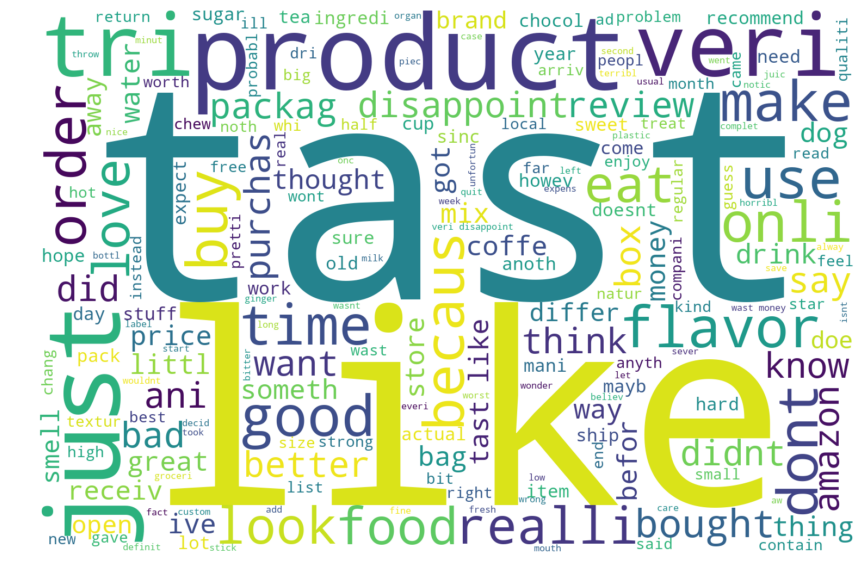

In [59]:
PlotWordCloud(NegD)

**This is a Word Cloud for all the negative reviews in the corpus.**<br>
**This Word Cloud plot correponds to the most frequent words in all negative reviews based on IDF values. More is the IDF Value for a word the less frequent is the word in the corpus.**

In [66]:
tfidf_vect = TfidfVectorizer(ngram_range = (1,2))

In [67]:
Data_TFIDF = tfidf_vect.fit_transform(Data["ProcessedText"].values)

In [68]:
Data_TFIDF.shape

(10000, 237703)

In [69]:
type(Data_TFIDF)

scipy.sparse.csr.csr_matrix

In [70]:
Data_TFIDF_Std = StandardScaler(with_mean = False).fit_transform(Data_TFIDF)

In [71]:
print(Data_TFIDF_Std.shape)
print(type(Data_TFIDF_Std))

(10000, 237703)
<class 'scipy.sparse.csr.csr_matrix'>


### Task 1. Split train and test data in a ratio of 80:20. 

In [72]:
train_TFIDF, test_TFIDF, train_labels_TFIDF, test_labels_TFIDF = train_test_split(Data_TFIDF_Std, Data_Labels, test_size = 0.2)

In [73]:
train_TFIDF.shape, test_TFIDF.shape, train_labels_TFIDF.shape, test_labels_TFIDF.shape

((8000, 237703), (2000, 237703), (8000,), (2000,))

### Task 2. Perform GridSearch Cross Validation and Random Search Cross Validation to find optimal Value of C and Gamma.

In [135]:
#when gamma value decreases then RBF kernel increases
clf = SVC()
    
hyper_parameters = {'kernel': ['rbf'], 'gamma': [10**-8, 10**-6, 10**-4], 'C': [100, 500, 1000, 2000]}
bestCV = GridSearchCV(clf, hyper_parameters, scoring = "accuracy", cv = 3)
bestCV.fit(train_TFIDF, train_labels_TFIDF)
    
print(bestCV.best_estimator_)

SVC(C=2000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-08, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [136]:
best_parameter = bestCV.best_params_
best_parameter

{'C': 2000, 'gamma': 1e-08, 'kernel': 'rbf'}

In [137]:
scoreData = bestCV.grid_scores_
scoreData

[mean: 0.52800, std: 0.00495, params: {'C': 100, 'gamma': 1e-08, 'kernel': 'rbf'},
 mean: 0.82188, std: 0.01049, params: {'C': 100, 'gamma': 1e-06, 'kernel': 'rbf'},
 mean: 0.50338, std: 0.00015, params: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'},
 mean: 0.81688, std: 0.01265, params: {'C': 500, 'gamma': 1e-08, 'kernel': 'rbf'},
 mean: 0.82188, std: 0.01049, params: {'C': 500, 'gamma': 1e-06, 'kernel': 'rbf'},
 mean: 0.50338, std: 0.00015, params: {'C': 500, 'gamma': 0.0001, 'kernel': 'rbf'},
 mean: 0.84237, std: 0.01116, params: {'C': 1000, 'gamma': 1e-08, 'kernel': 'rbf'},
 mean: 0.82188, std: 0.01049, params: {'C': 1000, 'gamma': 1e-06, 'kernel': 'rbf'},
 mean: 0.50338, std: 0.00015, params: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'},
 mean: 0.84500, std: 0.00992, params: {'C': 2000, 'gamma': 1e-08, 'kernel': 'rbf'},
 mean: 0.82188, std: 0.01049, params: {'C': 2000, 'gamma': 1e-06, 'kernel': 'rbf'},
 mean: 0.50338, std: 0.00015, params: {'C': 2000, 'gamma': 0.0001, 'kernel': 'r

In [138]:
error = []
eachError = []
for i in range(12):
    eachError.append(1 - scoreData[i][1])
    if i == 2 or i == 5 or i == 8 or i == 11:
        error.append(eachError)
        eachError = []

In [139]:
error

[[0.472, 0.17812499999999998, 0.496625],
 [0.18312499999999998, 0.17812499999999998, 0.496625],
 [0.15762500000000002, 0.17812499999999998, 0.496625],
 [0.15500000000000003, 0.17812499999999998, 0.496625]]

In [140]:
columnNames = [10**-8, 10**-6, 10**-4]

In [141]:
errorFrame = pd.DataFrame(error, columns = columnNames)

In [142]:
errorFrame

,1e-08,1e-06,0.0001
0,0.472000,0.178125,0.496625
1,0.183125,0.178125,0.496625
2,0.157625,0.178125,0.496625
3,0.155000,0.178125,0.496625


In [143]:
indexNames = [100, 500, 1000, 2000]
errorFrame["C"] = indexNames

In [144]:
errorFrame

,1e-08,1e-06,0.0001,C
0,0.472000,0.178125,0.496625,100
1,0.183125,0.178125,0.496625,500
2,0.157625,0.178125,0.496625,1000
3,0.155000,0.178125,0.496625,2000


In [145]:
errorFrame.set_index("C", append = False, drop = True, inplace = True)

In [146]:
errorFrame

,1e-08,1e-06,0.0001
C,,,
100,0.472000,0.178125,0.496625
500,0.183125,0.178125,0.496625
1000,0.157625,0.178125,0.496625
2000,0.155000,0.178125,0.496625


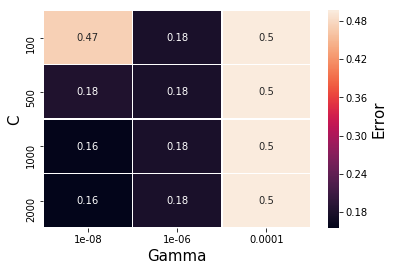

In [147]:
ax = sns.heatmap(errorFrame, annot = True, linewidths=.5)
ax.figure.axes[0].set_xlabel('Gamma', size = 15)
ax.figure.axes[0].set_ylabel('C', size = 15)
ax.figure.axes[-1].set_ylabel('Error', size = 15)
plot.show()

**Here above in heatmap you can see that the error is minimum when gamma value is 10^-8 and C value is 2000. Therefore, from grid search we are considering our C value as 2000 and Gamma Value as 10^-8**

In [148]:
n = list(np.random.normal(loc=2000, scale=500, size = 100))  #taking 100 numbers which are distributed normally with mean = 2000
                                                            #and std-dev = 500

In [149]:
k = []
for i in n:
    k.append(abs(i))

In [150]:
#when gamma value decreases then RBF kernel increases
clf = SVC()
    
hyper_parameters2 = {'kernel': ['rbf'], 'gamma': [10**-8, 10**-6], 'C': k}

bestCV_random = RandomizedSearchCV(clf, hyper_parameters2, n_iter = 4, scoring = "accuracy", cv = 3)

bestCV_random.fit(train_TFIDF, train_labels_TFIDF)
print(bestCV_random.best_estimator_)

SVC(C=2447.5558059680925, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-08, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [151]:
best_random_parameter = bestCV_random.best_params_ 
best_random_parameter["C"]

2447.5558059680925

In [152]:
scoreRandomData = bestCV_random.grid_scores_
scoreRandomData

[mean: 0.84575, std: 0.00976, params: {'kernel': 'rbf', 'gamma': 1e-08, 'C': 2447.5558059680925},
 mean: 0.84500, std: 0.00940, params: {'kernel': 'rbf', 'gamma': 1e-08, 'C': 1636.881474751077},
 mean: 0.82188, std: 0.01049, params: {'kernel': 'rbf', 'gamma': 1e-06, 'C': 1645.657293928913},
 mean: 0.82188, std: 0.01049, params: {'kernel': 'rbf', 'gamma': 1e-06, 'C': 1460.31104996981}]

**Here, above as you can see that error becomes least at C value 2447.555 and gamma value 10^-8.**

In [153]:
# We are taking our hyper-parameter C as the average of best C computed from gridSearchCV and RandomSearchCV
FinalHP = (best_parameter["C"] + best_random_parameter["C"]) / 2
FinalHP

2223.7779029840462

### Task 3. Apply Support Vector Machine using RBF kernel and report accuracy.

In [161]:
model = SVC(C = FinalHP, kernel = "rbf", gamma = 10**-9)

model.fit(train_TFIDF, train_labels_TFIDF)

prediction = model.predict(test_TFIDF)

AccuracyScore = accuracy_score(test_labels_TFIDF, prediction) * 100

print("Accuracy score of SVC = "+str(AccuracyScore)+"%")

Accuracy score of SVC = 79.9%


### Task 4. Check for train error.

In [163]:
model = SVC(C = FinalHP, kernel = "rbf", gamma = 10**-9)

model.fit(train_TFIDF, train_labels_TFIDF)

prediction2 = model.predict(train_TFIDF)

AccuracyScore2 = accuracy_score(train_labels_TFIDF, prediction2)

print("Train error of SVC = "+str(1 - AccuracyScore2))

Train error of SVC = 0.00187499999999996


**By gamma value of 10^-8, our model was over-fitting, therefore, we have decided to change the value of gamma to 10^-9**

## 2. Avg W2V

In [32]:
i = 0
listOfSentences = []
for sentence in Data["ProcessedText"].values:
    subSentence = []
    for word in sentence.split():
        subSentence.append(word)
        
    listOfSentences.append(subSentence)

In [33]:
print(Data['ProcessedText'].values[0])
print("\n")
print(listOfSentences[0:2])
print("\n")
print(type(listOfSentences))

this was realli good idea and the final product outstand use the decal car window and everybodi ask where bought the decal made two thumb


[['this', 'was', 'realli', 'good', 'idea', 'and', 'the', 'final', 'product', 'outstand', 'use', 'the', 'decal', 'car', 'window', 'and', 'everybodi', 'ask', 'where', 'bought', 'the', 'decal', 'made', 'two', 'thumb'], ['just', 'receiv', 'shipment', 'and', 'could', 'hard', 'wait', 'tri', 'this', 'product', 'love', 'which', 'what', 'call', 'them', 'instead', 'sticker', 'becaus', 'they', 'can', 'remov', 'easili', 'daughter', 'design', 'sign', 'print', 'revers', 'use', 'her', 'car', 'window', 'they', 'print', 'beauti', 'have', 'the', 'print', 'shop', 'program', 'go', 'have', 'lot', 'fun', 'with', 'this', 'product', 'becaus', 'there', 'are', 'window', 'everywher', 'and', 'other', 'surfac', 'like', 'screen', 'and', 'comput', 'monitor']]


<class 'list'>


In [34]:
w2vModel = gensim.models.Word2Vec(listOfSentences, size=300, min_count=5, workers=4)

In [35]:
# compute average word2vec for each review.
sentenceAsW2V = []
for sentence in listOfSentences:
    sentenceVector = np.zeros(300)
    TotalWordsPerSentence = 0
    for word in sentence:
        try:
            vect = w2vModel.wv[word]
            sentenceVector += vect
            TotalWordsPerSentence += 1
        except:
            pass
    sentenceVector /= TotalWordsPerSentence
    sentenceAsW2V.append(sentenceVector)

print(type(sentenceAsW2V))
print(len(sentenceAsW2V))
print(len(sentenceAsW2V[0]))

<class 'list'>
10000
300


In [36]:
standardized_Avg_w2v = StandardScaler().fit_transform(sentenceAsW2V)
print(standardized_Avg_w2v.shape)
print(type(standardized_Avg_w2v))

(10000, 300)
<class 'numpy.ndarray'>


### Task 1. Split train and test data in a ratio of 80:20.

In [37]:
train_AvgW2V, test_AvgW2V, train_labels_AvgW2V, test_labels_AvgW2V = train_test_split(standardized_Avg_w2v, Data_Labels, test_size = 0.2)

In [38]:
train_AvgW2V.shape, test_AvgW2V.shape, train_labels_AvgW2V.shape, test_labels_AvgW2V.shape

((8000, 300), (2000, 300), (8000,), (2000,))

### Task 2. Perform GridSearch Cross Validation and Random Search Cross Validation to find optimal Value of C and Gamma.

In [80]:
#when gamma value decreases then RBF kernel increases
clf = SVC()
    
hyper_parameters = {'kernel': ['rbf'], 'gamma': [10**-8, 10**-7, 10**-5], 'C': [10, 100, 500, 1000]}
bestCV = GridSearchCV(clf, hyper_parameters, scoring = "accuracy", cv = 3)
bestCV.fit(train_AvgW2V, train_labels_AvgW2V)
    
print(bestCV.best_estimator_)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [81]:
best_parameter = bestCV.best_params_ 
best_parameter["C"]

1000

In [82]:
scoreData = bestCV.grid_scores_
scoreData

[mean: 0.50138, std: 0.00009, params: {'C': 10, 'gamma': 1e-08, 'kernel': 'rbf'},
 mean: 0.50187, std: 0.00055, params: {'C': 10, 'gamma': 1e-07, 'kernel': 'rbf'},
 mean: 0.77587, std: 0.00996, params: {'C': 10, 'gamma': 1e-05, 'kernel': 'rbf'},
 mean: 0.50187, std: 0.00055, params: {'C': 100, 'gamma': 1e-08, 'kernel': 'rbf'},
 mean: 0.75200, std: 0.01030, params: {'C': 100, 'gamma': 1e-07, 'kernel': 'rbf'},
 mean: 0.78738, std: 0.01295, params: {'C': 100, 'gamma': 1e-05, 'kernel': 'rbf'},
 mean: 0.73938, std: 0.01336, params: {'C': 500, 'gamma': 1e-08, 'kernel': 'rbf'},
 mean: 0.76987, std: 0.01005, params: {'C': 500, 'gamma': 1e-07, 'kernel': 'rbf'},
 mean: 0.79438, std: 0.01080, params: {'C': 500, 'gamma': 1e-05, 'kernel': 'rbf'},
 mean: 0.75175, std: 0.01012, params: {'C': 1000, 'gamma': 1e-08, 'kernel': 'rbf'},
 mean: 0.77563, std: 0.01059, params: {'C': 1000, 'gamma': 1e-07, 'kernel': 'rbf'},
 mean: 0.79863, std: 0.00705, params: {'C': 1000, 'gamma': 1e-05, 'kernel': 'rbf'}]

In [83]:
error2 = []
eachError2 = []
for i in range(12):
    eachError2.append(1 - scoreData[i][1])
    if i == 2 or i == 5 or i == 8 or i == 11:
        error2.append(eachError2)
        eachError2 = []
error2

[[0.498625, 0.49812500000000004, 0.22412500000000002],
 [0.49812500000000004, 0.248, 0.21262499999999995],
 [0.260625, 0.23012500000000002, 0.20562499999999995],
 [0.24824999999999997, 0.224375, 0.20137499999999997]]

In [84]:
columnNames2 = [10**-8, 10**-7, 10**-5]
errorFrame2 = pd.DataFrame(error2, columns = columnNames2)
errorFrame2

,1e-08,1e-07,1e-05
0,0.498625,0.498125,0.224125
1,0.498125,0.248000,0.212625
2,0.260625,0.230125,0.205625
3,0.248250,0.224375,0.201375


In [85]:
indexNames2 = [10, 100, 500, 1000]
errorFrame2["C"] = indexNames2
errorFrame2

,1e-08,1e-07,1e-05,C
0,0.498625,0.498125,0.224125,10
1,0.498125,0.248000,0.212625,100
2,0.260625,0.230125,0.205625,500
3,0.248250,0.224375,0.201375,1000


In [86]:
errorFrame2.set_index("C", append = False, drop = True, inplace = True)
errorFrame2

,1e-08,1e-07,1e-05
C,,,
10,0.498625,0.498125,0.224125
100,0.498125,0.248000,0.212625
500,0.260625,0.230125,0.205625
1000,0.248250,0.224375,0.201375


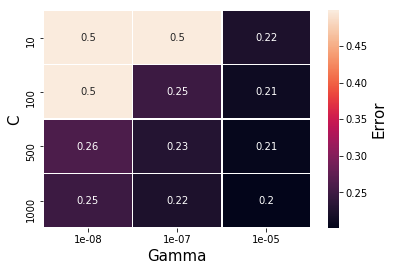

In [87]:
ax2 = sns.heatmap(errorFrame2, annot = True, linewidths=.5)
ax2.figure.axes[0].set_xlabel('Gamma', size = 15)
ax2.figure.axes[0].set_ylabel('C', size = 15)
ax2.figure.axes[-1].set_ylabel('Error', size = 15)
plot.show()

**Here above in heatmap you can see that the error is minimum when gamma value is 10^-5 and C value is 1000. Therefore, from grid search we are considering our C value as 1000 and Gamma Value as 10^-5**

In [90]:
n = list(np.random.normal(loc=1000, scale=400, size = 100))  #taking 100 numbers which are distributed normally with mean = 1000
                                                            #and std-dev = 400

In [97]:
#when gamma value decreases then RBF kernel increases
clf = SVC()
    
hyper_parameters3 = {'kernel': ['rbf'], 'gamma': [10**-6, 10**-5], 'C': n}

bestCV_random2 = RandomizedSearchCV(clf, hyper_parameters3, n_iter = 4, scoring = "accuracy", cv = 3)

bestCV_random2.fit(train_AvgW2V, train_labels_AvgW2V)
print(bestCV_random2.best_estimator_)

SVC(C=1302.608385476245, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [98]:
best_random_parameter2 = bestCV_random2.best_params_ 
best_random_parameter2["C"]

1302.608385476245

In [99]:
scoreRandomData2 = bestCV_random2.grid_scores_
scoreRandomData2

[mean: 0.79975, std: 0.00796, params: {'kernel': 'rbf', 'gamma': 1e-05, 'C': 1467.1596660697855},
 mean: 0.80012, std: 0.00771, params: {'kernel': 'rbf', 'gamma': 1e-05, 'C': 1302.608385476245},
 mean: 0.79837, std: 0.00717, params: {'kernel': 'rbf', 'gamma': 1e-05, 'C': 1073.1100023854217},
 mean: 0.78625, std: 0.01277, params: {'kernel': 'rbf', 'gamma': 1e-06, 'C': 772.5827460396076}]

**Here, above as you can see that error becomes least at C value 1302.608 and gamma value 10^-5.**

In [100]:
# We are taking our hyper-parameter C as the average of best C computed from gridSearchCV and RandomSearchCV
FinalHP2 = (best_parameter["C"] + best_random_parameter2["C"]) / 2
FinalHP2

1151.3041927381225

### Task 3. Apply Support Vector Machine using RBF kernel and report accuracy.

In [101]:
model = SVC(C = FinalHP2, kernel = "rbf", gamma = 10**-5)

model.fit(train_AvgW2V, train_labels_AvgW2V)

prediction3 = model.predict(test_AvgW2V)

AccuracyScore3 = accuracy_score(test_labels_AvgW2V, prediction3) * 100

print("Accuracy score of SVC = "+str(AccuracyScore3)+"%")

Accuracy score of SVC = 81.25%


In [102]:
Confusion_Matrix = confusion_matrix(test_labels_AvgW2V, prediction3)
print("Confusion Matrix on L2 regularization  \n"+str(Confusion_Matrix))

Confusion Matrix on L2 regularization  
[[834 155]
 [220 791]]


In [103]:
tn, fp, fn, tp = confusion_matrix(test_labels_AvgW2V, prediction3).ravel()
tn, fp, fn, tp

(834, 155, 220, 791)

### Trying SGD Classifier on SVM

In [54]:
clf = linear_model.SGDClassifier(loss="hinge")

clf.fit(train_AvgW2V, train_labels_AvgW2V)

prediction_SGD = clf.predict(test_AvgW2V)

AccuracyScore_SGD = accuracy_score(test_labels_AvgW2V, prediction_SGD) * 100

print("Accuracy score of SVC on SGDClassifier = "+str(AccuracyScore_SGD)+"%")

Accuracy score of SVC on SGDClassifier = 78.2%


C:\Users\GauravP\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


### Task 4. Check for train error.

In [104]:
model = SVC(C = FinalHP, kernel = "rbf", gamma = 10**-5)

model.fit(train_AvgW2V, train_labels_AvgW2V)

prediction3 = model.predict(train_AvgW2V)

AccuracyScore3 = accuracy_score(train_labels_AvgW2V, prediction3)

print("Train error of SVC = "+str(1 - AccuracyScore3))

Train error of SVC = 0.19625000000000004


## 3. TFIDF-W2V

In [39]:
tfidf_vect = TfidfVectorizer(ngram_range = (1,2))
tfidf = tfidf_vect.fit_transform(Data["ProcessedText"].values)

In [40]:
w2v_Model = gensim.models.Word2Vec(listOfSentences, size=300, min_count=5, workers=4)

In [41]:
print(tfidf.shape)
print(type(tfidf))

(10000, 237703)
<class 'scipy.sparse.csr.csr_matrix'>


In [42]:
# TF-IDF weighted Word2Vec
tfidf_features = tfidf_vect.get_feature_names()

tfidf_w2v = []
reviews = 0

for sentence in listOfSentences:
    sentenceVector = np.zeros(300)
    weightTfidfSum = 0
    for word in sentence:
        try:
            W2V_Vector = w2v_Model.wv[word]
            tfidfVector = tfidf[reviews, tfidf_features.index(word)]
            sentenceVector += (W2V_Vector * tfidfVector)
            weightTfidfSum += tfidfVector
        except:
            pass
    sentenceVector /= weightTfidfSum
    tfidf_w2v.append(sentenceVector)
    reviews += 1

In [43]:
standardized_tfidf_w2v = StandardScaler().fit_transform(tfidf_w2v)
print(standardized_tfidf_w2v.shape)
print(type(standardized_tfidf_w2v))

(10000, 300)
<class 'numpy.ndarray'>


### Task 1. Split train and test data in a ratio of 80:20. 

In [45]:
train_TFIDF_W2V, test_TFIDF_W2V, train_labels_TFIDF_W2V, test_labels_TFIDF_W2V = train_test_split(standardized_tfidf_w2v, Data_Labels, test_size = 0.2)

In [46]:
train_TFIDF_W2V.shape, test_TFIDF_W2V.shape, train_labels_TFIDF_W2V.shape, test_labels_TFIDF_W2V.shape 

((8000, 300), (2000, 300), (8000,), (2000,))

### Task 2. Perform GridSearch Cross Validation and Random Search Cross Validation to find optimal Value of C and Gamma.

In [47]:
#when gamma value decreases then RBF kernel increases
clf = SVC()
    
hyper_parameters = {'kernel': ['rbf'], 'gamma': [10**-8, 10**-7, 10**-5], 'C': [10, 100, 500, 1000]}
bestCV = GridSearchCV(clf, hyper_parameters, scoring = "accuracy", cv = 3)
bestCV.fit(train_TFIDF_W2V, train_labels_TFIDF_W2V)
    
print(bestCV.best_estimator_)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [48]:
best_parameter = bestCV.best_params_ 
best_parameter["C"]

1000

In [49]:
scoreData = bestCV.grid_scores_
scoreData

[mean: 0.50200, std: 0.00009, params: {'C': 10, 'gamma': 1e-08, 'kernel': 'rbf'},
 mean: 0.50225, std: 0.00027, params: {'C': 10, 'gamma': 1e-07, 'kernel': 'rbf'},
 mean: 0.75125, std: 0.00521, params: {'C': 10, 'gamma': 1e-05, 'kernel': 'rbf'},
 mean: 0.50225, std: 0.00027, params: {'C': 100, 'gamma': 1e-08, 'kernel': 'rbf'},
 mean: 0.72850, std: 0.00621, params: {'C': 100, 'gamma': 1e-07, 'kernel': 'rbf'},
 mean: 0.76338, std: 0.00674, params: {'C': 100, 'gamma': 1e-05, 'kernel': 'rbf'},
 mean: 0.70937, std: 0.00428, params: {'C': 500, 'gamma': 1e-08, 'kernel': 'rbf'},
 mean: 0.74600, std: 0.00536, params: {'C': 500, 'gamma': 1e-07, 'kernel': 'rbf'},
 mean: 0.77550, std: 0.01129, params: {'C': 500, 'gamma': 1e-05, 'kernel': 'rbf'},
 mean: 0.72825, std: 0.00616, params: {'C': 1000, 'gamma': 1e-08, 'kernel': 'rbf'},
 mean: 0.75138, std: 0.00582, params: {'C': 1000, 'gamma': 1e-07, 'kernel': 'rbf'},
 mean: 0.78075, std: 0.01280, params: {'C': 1000, 'gamma': 1e-05, 'kernel': 'rbf'}]

In [51]:
error = []
eachError = []
for i in range(12):
    eachError.append(1 - scoreData[i][1])
    if i == 2 or i == 5 or i == 8 or i == 11:
        error.append(eachError)
        eachError = []
error

[[0.498, 0.49775, 0.24875000000000003],
 [0.49775, 0.27149999999999996, 0.23662499999999997],
 [0.290625, 0.254, 0.22450000000000003],
 [0.27175000000000005, 0.24862499999999998, 0.21924999999999994]]

In [52]:
columnNames = [10**-8, 10**-7, 10**-5]
errorFrame = pd.DataFrame(error, columns = columnNames)
errorFrame

,1e-08,1e-07,1e-05
0,0.498000,0.497750,0.248750
1,0.497750,0.271500,0.236625
2,0.290625,0.254000,0.224500
3,0.271750,0.248625,0.219250


In [53]:
indexNames = [10, 100, 500, 1000]
errorFrame["C"] = indexNames
errorFrame

,1e-08,1e-07,1e-05,C
0,0.498000,0.497750,0.248750,10
1,0.497750,0.271500,0.236625,100
2,0.290625,0.254000,0.224500,500
3,0.271750,0.248625,0.219250,1000


In [54]:
errorFrame.set_index("C", append = False, drop = True, inplace = True)
errorFrame

,1e-08,1e-07,1e-05
C,,,
10,0.498000,0.497750,0.248750
100,0.497750,0.271500,0.236625
500,0.290625,0.254000,0.224500
1000,0.271750,0.248625,0.219250


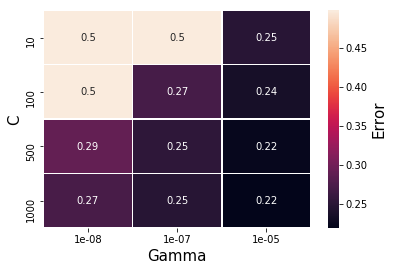

In [55]:
ax = sns.heatmap(errorFrame, annot = True, linewidths=.5)
ax.figure.axes[0].set_xlabel('Gamma', size = 15)
ax.figure.axes[0].set_ylabel('C', size = 15)
ax.figure.axes[-1].set_ylabel('Error', size = 15)
plot.show()

**Here above in heatmap you can see that the error is minimum when gamma value is 10^-5 and C value is 1000. Therefore, from grid search we are considering our C value as 1000 and Gamma Value as 10^-5**

In [56]:
n = list(np.random.normal(loc=1000, scale=3000, size = 100))  #taking 100 numbers which are distributed normally with mean = 1000
                                                            #and std-dev = 300

In [58]:
#when gamma value decreases then RBF kernel increases
clf = SVC()
    
hyper_parameters = {'kernel': ['rbf'], 'gamma': [10**-6, 10**-5], 'C': n}

bestCV_random = RandomizedSearchCV(clf, hyper_parameters, n_iter = 4, scoring = "accuracy", cv = 3)

bestCV_random.fit(train_TFIDF_W2V, train_labels_TFIDF_W2V)
print(bestCV_random.best_estimator_)

SVC(C=967.8423171725512, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [59]:
best_random_parameter = bestCV_random.best_params_ 
best_random_parameter["C"]

967.8423171725512

In [60]:
best_random_parameter = bestCV_random.best_params_
best_random_parameter

{'C': 967.8423171725512, 'gamma': 1e-05, 'kernel': 'rbf'}

**Here, above as you can see that error becomes least at C value 967.842 and gamma value 10^-5.**

In [61]:
# We are taking our hyper-parameter C as the average of best C computed from gridSearchCV and RandomSearchCV
FinalHP = (best_parameter["C"] + best_random_parameter["C"]) / 2
FinalHP

983.9211585862756

### Task 3. Apply Support Vector Machine using RBF kernel and report accuracy.

In [62]:
model = SVC(C = FinalHP, kernel = "rbf", gamma = 10**-5)

model.fit(train_TFIDF_W2V, train_labels_TFIDF_W2V)

prediction = model.predict(test_TFIDF_W2V)

AccuracyScore = accuracy_score(test_labels_TFIDF_W2V, prediction) * 100

print("Accuracy score of SVC = "+str(AccuracyScore)+"%")

Accuracy score of SVC = 78.95%


In [63]:
Confusion_Matrix = confusion_matrix(test_labels_TFIDF_W2V, prediction)
print("Confusion Matrix on L2 regularization  \n"+str(Confusion_Matrix))

Confusion Matrix on L2 regularization  
[[795 189]
 [232 784]]


In [64]:
tn, fp, fn, tp = confusion_matrix(test_labels_TFIDF_W2V, prediction).ravel()
tn, fp, fn, tp

(795, 189, 232, 784)

### Task 4. Check for train error.

In [65]:
model = SVC(C = FinalHP, kernel = "rbf", gamma = 10**-5)

model.fit(train_TFIDF_W2V, train_labels_TFIDF_W2V)

prediction = model.predict(train_TFIDF_W2V)

AccuracyScore = accuracy_score(train_labels_TFIDF_W2V, prediction)

print("Train error of SVC = "+str(1 - AccuracyScore))

Train error of SVC = 0.20375


# Summary

## TFIDF
**1. Optimal Value of C from Grid Search = 2000**<br>
**2. Optimal Value of gamma from Grid Search  = 10^-8**<br>
**3. Optimal Value of C from Random Search = 2447.555**<br>
**4. Optimal Value of gamma from Random Search = 10^-8**<br>
**5. Final C and gamma value for model are 2223.777 & 10^-9 respectively**<br>
**6. Accuracy = 79.9%**<br>
**7. Train Error = 0.00187499**<br>
## Avg W2V
**1. Optimal Value of C from Grid Search = 1000**<br>
**2. Optimal Value of gamma from Grid Search  = 10^-5**<br>
**3. Optimal Value of C from Random Search = 1302.608**<br>
**4. Optimal Value of gamma from Random Search = 10^-5**<br>
**5. Final C and gamma value for model are 1151.304 & 10^-5 respectively**<br>
**6. Accuracy = 81.25%**<br>
**7. Train Error = 0.196**<br>
## TFIDF-W2V
**1. Optimal Value of C from Grid Search = 1000**<br>
**2. Optimal Value of gamma from Grid Search = 10^-5**<br>
**3. Optimal Value of C from Random Search = 967.842**<br>
**4. Optimal Value of gamma from Random Search = 10^-5**<br>
**5. Final C and gamma value for model are 983.921 & 10^-5 respectively **<br>
**6. Accuracy = 78.95%**<br>
**7. Train Error = 0.20375**<br>